In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
nfft = 4096
integrate = 1171
fs = 480e3
tstart = np.datetime64('2020-12-27T13:53:02.170753')

In [3]:
auto = np.array([[
    np.fromfile(f'/home/destevez/CE5/2020-12-27/CE5_2020-12-27T13:52:48.871351_0{pol}_{channel}.crossspec',
                dtype = 'float32').reshape((-1,nfft))
    for pol in ('xx', 'yy')] for channel in [1,3]])
cross = np.array([
    np.fromfile(f'/home/destevez/CE5/2020-12-27/CE5_2020-12-27T13:52:48.871351_0xy_{channel}.crossspec',
                dtype = 'complex64').reshape((-1,nfft))
    for channel in [1,3]])

gain_offset = np.average((np.median(auto[:,0], axis = 2)/np.median(auto[:,1], axis = 2)), axis = 1)
auto[:,1] *= gain_offset[:,np.newaxis,np.newaxis]
cross *= np.sqrt(gain_offset[:,np.newaxis,np.newaxis])
cross *= np.exp(-1j*np.deg2rad(59))*(-1j) # correct for X-Y phase offset
# calibrated with Tianwen-1 2020-12-19

In [4]:
t = tstart + int(1e9 * integrate * nfft / fs) * np.timedelta64(1, 'ns') * np.arange(auto.shape[2])

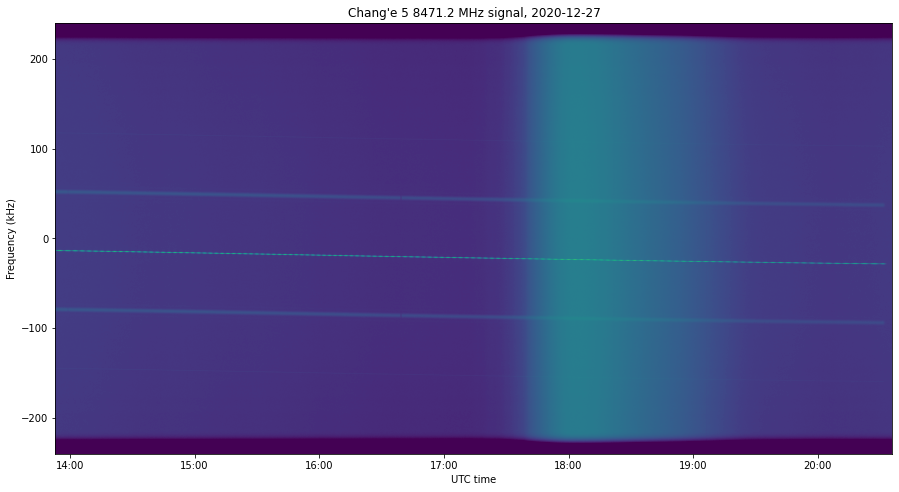

In [5]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(10*np.log10(auto[0,0]+auto[0,1])[:,::-1].T, extent = (mdates.date2num(t[0]),mdates.date2num(t[-1]), -240, 240),
          aspect = 3e-4, vmin = 16, vmax = 26)
plt.gca().set_xlim((t[0], t[-1]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Frequency (kHz)')
plt.xlabel('UTC time')
plt.title('Chang\'e 5 8471.2 MHz signal, 2020-12-27');

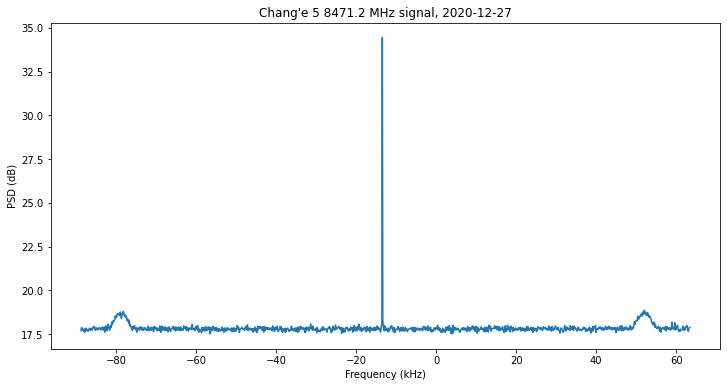

In [6]:
plt.figure(figsize = (12,6), facecolor = 'w')
sel = slice(1290,2590)
freq = np.fft.fftshift(np.fft.fftfreq(auto[0,0].shape[1], 1/fs))
plt.plot(freq[sel]*1e-3, 10*np.log10(auto[0,0]+auto[0,1])[0,sel])
plt.title('Chang\'e 5 8471.2 MHz signal, 2020-12-27')
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (dB)');

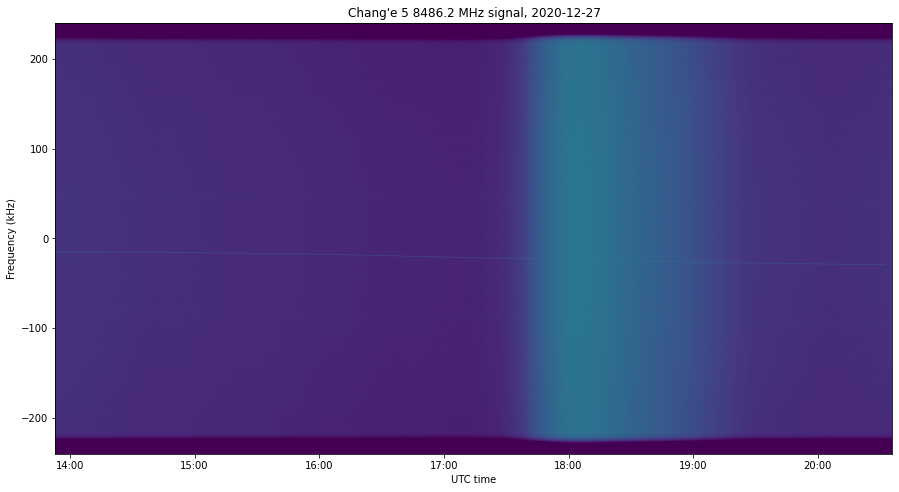

In [7]:
plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(10*np.log10(auto[1,0]+auto[1,1])[:,::-1].T, extent = (mdates.date2num(t[0]),mdates.date2num(t[-1]), -240, 240),
          aspect = 3e-4, vmin = 17, vmax = 27)
plt.gca().set_xlim((t[0], t[-1]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Frequency (kHz)')
plt.xlabel('UTC time')
plt.title('Chang\'e 5 8486.2 MHz signal, 2020-12-27');

In [8]:
signal_peak = np.argmax(auto[:,0] + auto[:,1], axis = 2)
offsets = np.arange(-2,3)
signal_auto = np.zeros((auto.shape[0], auto.shape[2], auto.shape[1]))
signal_cross = np.zeros((cross.shape[0], cross.shape[1]), dtype = 'complex')
for offset in np.arange(-2,3):
    signal_auto += auto[np.arange(signal_peak.shape[0])[:,np.newaxis],
                       :,
                       np.arange(signal_peak.shape[1])[np.newaxis,:],
                       signal_peak + offset]
    signal_cross += cross[np.arange(signal_peak.shape[0])[:,np.newaxis],
                       np.arange(signal_peak.shape[1])[np.newaxis,:],
                       signal_peak + offset]
signal_auto /= offsets.size
signal_cross /= offsets.size
gain_auto = np.average(signal_auto[:,:,0] + signal_auto[:,:,1])
signal_auto /= gain_auto
signal_cross /= gain_auto

In [9]:
I = signal_auto[:,:,0] + signal_auto[:,:,1]
Q = signal_auto[:,:,0] - signal_auto[:,:,1]
U = 2*signal_cross.real
V = -2*signal_cross.imag
L = Q + 1j*U
P = np.sqrt(Q**2 + U**2 + V**2)

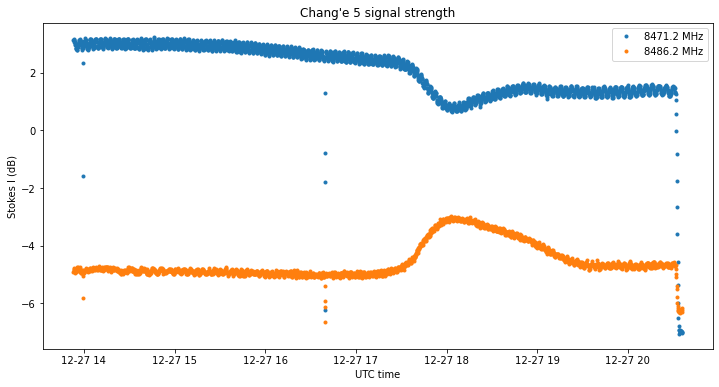

In [10]:
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.plot(t, 10*np.log10(I).T, '.')
plt.ylabel('Stokes I (dB)')
plt.xlabel('UTC time')
plt.title('Chang\'e 5 signal strength')
plt.legend(['8471.2 MHz', '8486.2 MHz']);

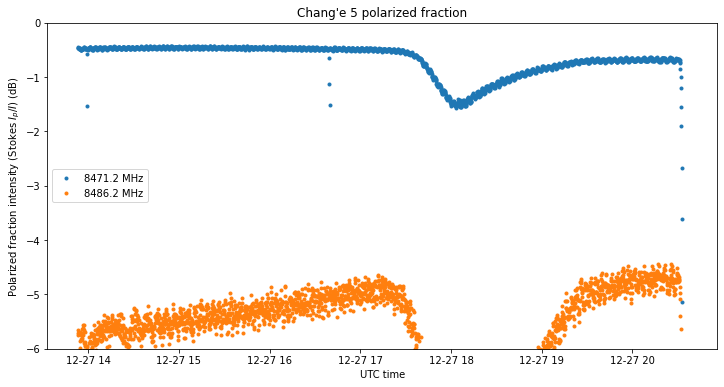

In [11]:
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.plot(t, 10*np.log10(P/I).T, '.')
plt.ylim((-6,0))
plt.ylabel('Polarized fraction intensity (Stokes $I_p/I$) (dB)')
plt.xlabel('UTC time')
plt.title('Chang\'e 5 polarized fraction')
plt.legend(['8471.2 MHz', '8486.2 MHz']);

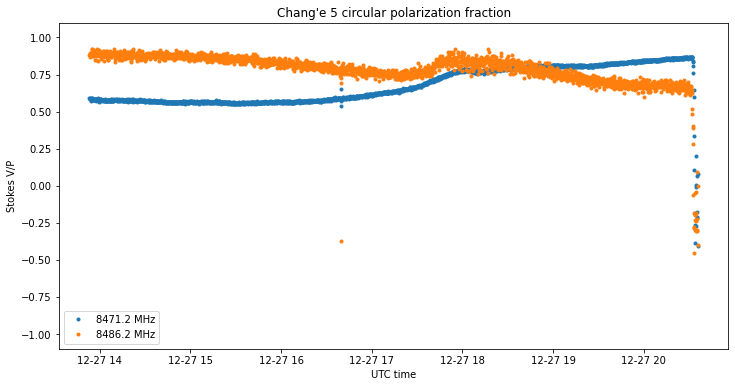

In [12]:
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.plot(t, (V/P).T, '.')
plt.ylabel('Stokes V/P')
plt.xlabel('UTC time')
plt.ylim((-1.1,1.1))
plt.title('Chang\'e 5 circular polarization fraction')
plt.legend(['8471.2 MHz', '8486.2 MHz']);

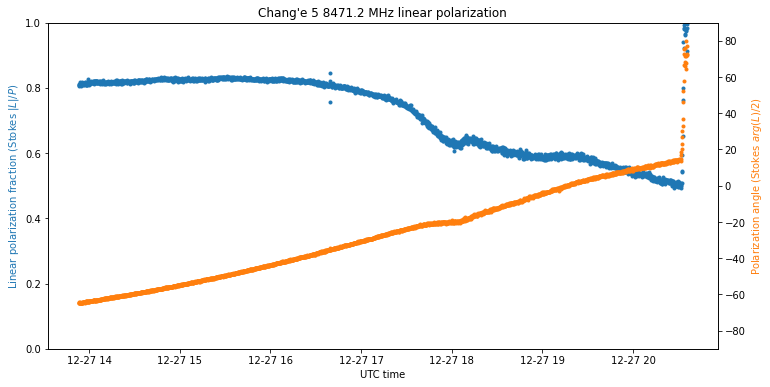

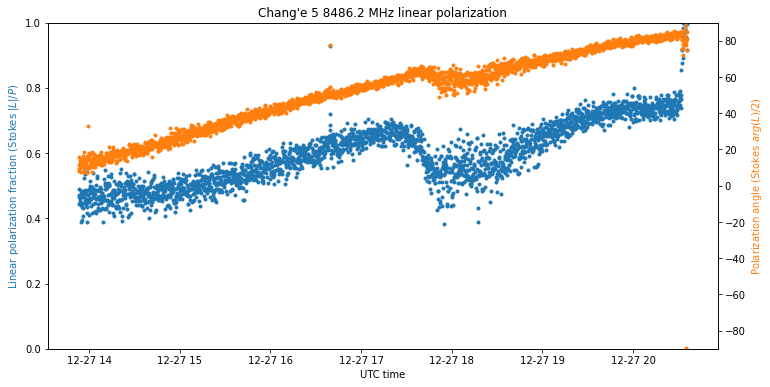

In [13]:
for j in range(2):
    plt.figure(figsize = (12, 6), facecolor = 'w')
    plt.plot(t, (np.abs(L)/P)[j], '.', color = 'C0')
    plt.ylim((0,1))
    plt.xlabel('UTC time')
    plt.ylabel('Linear polarization fraction (Stokes $|L|/P$)', color = 'C0')
    ax2 = plt.gca().twinx()
    plt.plot(t, np.rad2deg(np.angle(L)/2)[j], '.', color = 'C1')
    ax2.set_ylabel('Polarization angle (Stokes $arg(L)/2$)', color = 'C1')
    ax2.set_ylim((-90,90))
    freq = '8471.2' if j == 0 else '8486.2'
    plt.title(f'Chang\'e 5 {freq} MHz linear polarization');